# Imports

In [1]:
%tensorflow_version 2.x

import tensorflow as tf
import tensorflow_hub as hub

from tensorflow.keras import Sequential
from tensorflow.keras.utils import get_file
from tensorflow.keras.applications import ResNet152V2
from tensorflow.keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import os
import shutil
import numpy as np
import PIL.Image as Image
import matplotlib.pylab as plt

seed=1998
np.random.seed(seed)
tf.random.set_seed(seed)

TensorFlow 2.x selected.


In [2]:
!pip install googleimagedownloader

  Created wheel for requests-futures: filename=requests_futures-1.0.0-cp36-none-any.whl size=7012 sha256=594eaa0ab4e4ab9e2b991d04053a19aba514c894027eb4070e88c2fa82a7d63c
  Stored in directory: /root/.cache/pip/wheels/26/d0/f5/dc4e4a37bbe55c9acf967d2bd899152412c1e49c227f5395ff
Successfully built requests-futures


In [0]:
from googleimagedownloader.googleimagedownloader import GoogleImageDownloader

# Testing an pretrained classifier

In [0]:
IMAGE_SIZE = (224,224)

In [0]:
# classifier_url = 'https://tfhub.dev/google/imagenet/resnet_v2_152/feature_vector/4'
# classifier_url = 'https://tfhub.dev/google/imagenet/resnet_v2_152/classification/4'
# classifier_url = 'https://tfhub.dev/google/imagenet/resnet_v2_101/classification/4'
classifier_url ="https://tfhub.dev/google/imagenet/resnet_v2_50/classification/4" 

In [0]:
classifier = Sequential([
  hub.KerasLayer(classifier_url, input_shape=IMAGE_SIZE+(3,))
])

122880/116328 [===============================] - 0s 0us/step


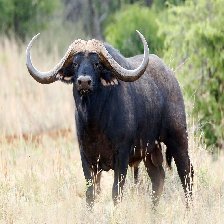

In [7]:
test_image = get_file('buff.jpg', 'https://assets.bwbx.io/images/users/iqjWHBFdfxIU/i3Yp1mXpDIMA/v2/1000x-1.jpg')
test_image = Image.open(test_image).resize(IMAGE_SIZE)
test_image

In [8]:
test_image = np.array(test_image)/255.0
test_image.shape

(224, 224, 3)

In [9]:
result = classifier.predict(test_image[np.newaxis, ...])
result.shape

(1, 1001)

In [10]:
predicted_class = np.argmax(result[0], axis=-1)
predicted_class

347

In [11]:
labels_path = get_file('ImageNetLabels.txt', 'https://storage.googleapis.com/download.tensorflow.org/data/ImageNetLabels.txt')
imagenet_labels = np.array(open(labels_path).read().splitlines())

16384/10484 [==============================================] - 0s 0us/step


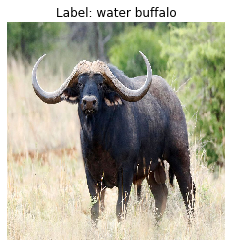

In [12]:
predicted_class_name = imagenet_labels[predicted_class]
plt.axis('off')
plt.title("Label: " + predicted_class_name, color = 'black')
plt.imshow(test_image)
plt.show()

# Creating the Transfer Learning Model

## Create the Eeveelutions dataset

In [0]:
# Eeveelutions Classifier :D 
# class_names = ['flareon', 'jolteon', 'vaporeon', 'umbreon', 'espeon', 'glaceon', 'sylveon', 'leafeon']
class_names = ['flareon', 'jolteon', 'vaporeon']
# class_names = ['flareon', 'jolteon']
path = 'eevelutions/dataset/'

train_dir = os.path.join(path, 'train')
validation_dir = os.path.join(path, 'validation')

train_fla_dir = os.path.join(train_dir, 'flareon')  
train_jol_dir = os.path.join(train_dir, 'jolteon')  
# train_vap_dir = os.path.join(train_dir, 'vaporeon')  
# train_umb_dir = os.path.join(train_dir, 'umbreon')
# train_esp_dir = os.path.join(train_dir, 'espeon')
# train_gla_dir = os.path.join(train_dir, 'glaceon')
# train_syl_dir = os.path.join(train_dir, 'sylveon')
# train_lea_dir = os.path.join(train_dir, 'leafeon')

validation_fla_dir = os.path.join(validation_dir, 'flareon') 
validation_jol_dir = os.path.join(validation_dir, 'jolteon')
# validation_vap_dir = os.path.join(validation_dir, 'vaporeon')
# validation_umb_dir = os.path.join(validation_dir, 'umbreon')
# validation_esp_dir = os.path.join(validation_dir, 'espeon')
# validation_gla_dir = os.path.join(validation_dir, 'glaceon')
# validation_syl_dir = os.path.join(validation_dir, 'sylveon')
# validation_lea_dir = os.path.join(validation_dir, 'leafeon')

if os.path.exists(path):
  shutil.rmtree(path)

os.makedirs(train_fla_dir)
os.makedirs(train_jol_dir)
# os.makedirs(train_vap_dir)
# os.makedirs(train_umb_dir)
# os.makedirs(train_esp_dir)
# os.makedirs(train_gla_dir)
# os.makedirs(train_syl_dir)
# os.makedirs(train_lea_dir)

os.makedirs(validation_fla_dir)    
os.makedirs(validation_jol_dir)
# os.makedirs(validation_vap_dir)
# os.makedirs(validation_umb_dir)
# os.makedirs(validation_esp_dir)
# os.makedirs(validation_gla_dir)
# os.makedirs(validation_syl_dir)
# os.makedirs(validation_lea_dir)


In [0]:
def manage_images(src, dest_train, dest_val, image_resize=IMAGE_SIZE, val_split=0.1, prefix=''):
  total = len(os.listdir(src))
  val = np.int(total*val_split)
  count = 0
  files = os.listdir(src)

  for file_name in files:
    try:
      dest = dest_train if count >= val else dest_val
      dest_file = os.path.join(dest, prefix + file_name) 

      img = Image.open(os.path.join(src,file_name))
      img.verify()
      # reopen because verify() was called
      # If you need to load the image after using this method, you must reopen the image file.
      # https://pillow.readthedocs.io/en/3.1.x/reference/Image.html
      img = Image.open(os.path.join(src,file_name))
      #resize
      img = img.resize(image_resize, Image.ANTIALIAS)
      #move
      img.save(dest_file)  
      count+=1 
    except Exception as e:
        print('Invalid image: ',file_name,e)
        if os.path.exists(dest_file):
          os.remove(dest_file)
  return


In [0]:
img_dir = os.path.realpath('Images/')

In [22]:
queries = ['eevelutions','pokemon','evee', '']
pos = 0
for query in queries:
  image = GoogleImageDownloader(Query='flareon '+query, numberImage=50)
  try:
    image.downloadImages()
  except Exception as e:
    print('Error ',e)
  #verify, resize, move and split sets
  manage_images(img_dir, train_fla_dir, validation_fla_dir,prefix=str(pos)+'-')
  pos+=1

https://www.google.co.in/search?q=flareon eevelutions&source=lnms&tbm=isch
Error  HTTPSConnectionPool(host='static1.fjcdn.com', port=443): Max retries exceeded with url: /comments/Though+flareon+is+quite+average+in+terms+of+the+eeveelutions+_1863b13e40bb043456fe16a27e50c072.jpg (Caused by NewConnectionError('<urllib3.connection.VerifiedHTTPSConnection object at 0x7feeaa34a518>: Failed to establish a new connection: [Errno 110] Connection timed out',))
Invalid image:  6.jpg cannot write mode RGBA as JPEG
Invalid image:  3.jpg cannot write mode RGBA as JPEG
https://www.google.co.in/search?q=flareon pokemon&source=lnms&tbm=isch
Total Time : 0:00:01.676761
Invalid image:  36.jpg cannot write mode RGBA as JPEG
Invalid image:  19.jpg cannot write mode RGBA as JPEG
Invalid image:  22.jpg cannot write mode RGBA as JPEG
Invalid image:  30.jpg cannot write mode P as JPEG
Invalid image:  2.jpg cannot write mode RGBA as JPEG
Invalid image:  11.jpg cannot write mode RGBA as JPEG
Invalid image:  41.

In [23]:
queries = ['eevelutions','pokemon','evee', '']
pos = 0
for query in queries:
  image = GoogleImageDownloader(Query='jolteon '+query, numberImage=50)
  try:
    image.downloadImages()
  except Exception as e:
    print('Error ',e)
  #verify, resize, move and split sets
  manage_images(img_dir, train_jol_dir, validation_jol_dir,prefix=str(pos)+'-')
  pos+=1

https://www.google.co.in/search?q=jolteon eevelutions&source=lnms&tbm=isch
Total Time : 0:00:01.506405
Invalid image:  39.jpg cannot write mode P as JPEG
Invalid image:  29.jpg cannot write mode RGBA as JPEG
Invalid image:  15.jpg cannot write mode RGBA as JPEG
Invalid image:  20.jpg cannot identify image file '/content/Images/20.jpg'
Invalid image:  47.jpg cannot identify image file '/content/Images/47.jpg'
Invalid image:  45.jpg cannot write mode RGBA as JPEG
Invalid image:  1.jpg cannot write mode RGBA as JPEG
Invalid image:  31.jpg cannot write mode P as JPEG
Invalid image:  13.jpg cannot write mode RGBA as JPEG
Invalid image:  18.jpg cannot write mode RGBA as JPEG
Invalid image:  8.jpg cannot identify image file '/content/Images/8.jpg'
https://www.google.co.in/search?q=jolteon pokemon&source=lnms&tbm=isch
Total Time : 0:00:00.000281
Invalid image:  39.jpg cannot write mode P as JPEG
Invalid image:  29.jpg cannot write mode RGBA as JPEG
Invalid image:  15.jpg cannot write mode RGBA

In [18]:
# queries = ['eevelutions','pokemon','evee', '']
# pos = 0
# for query in queries:
#   image = GoogleImageDownloader(Query='vaporeon '+query, numberImage=0)
#   try:
#     image.downloadImages()
#   except Exception as e:
#     print('Error ',e)
#   #verify, resize, move and split sets
#   manage_images(img_dir, train_vap_dir, validation_vap_dir,prefix=str(pos)+'-')
#   pos+=1

https://www.google.co.in/search?q=vaporeon eevelutions&source=lnms&tbm=isch
Total Time : 0:00:00.000309
Invalid image:  71.jpg cannot write mode RGBA as JPEG
Invalid image:  81.jpg cannot write mode RGBA as JPEG
Invalid image:  46.jpg cannot write mode RGBA as JPEG
Invalid image:  7.jpg cannot write mode P as JPEG
Invalid image:  2.jpg cannot write mode RGBA as JPEG
Invalid image:  77.jpg cannot write mode RGBA as JPEG
Invalid image:  24.jpg cannot write mode RGBA as JPEG
Invalid image:  86.jpg cannot write mode RGBA as JPEG
Invalid image:  16.jpg cannot write mode RGBA as JPEG
Invalid image:  28.jpg cannot write mode RGBA as JPEG
Invalid image:  58.jpg cannot write mode RGBA as JPEG
Invalid image:  47.jpg cannot write mode RGBA as JPEG
Invalid image:  64.jpg cannot write mode RGBA as JPEG
Invalid image:  45.jpg cannot write mode RGBA as JPEG
Invalid image:  80.jpg cannot identify image file '/content/Images/80.jpg'
Invalid image:  6.jpg cannot write mode RGBA as JPEG
Invalid image:  6

In [0]:
# queries = ['eevelutions','pokemon','evee', '']
# pos = 0
# for query in queries:
#   image = GoogleImageDownloader(Query='umbreon '+query, numberImage=0)
#   try:
#     image.downloadImages()
#   except Exception as e:
#     print('Error ',e)
#   #verify, resize, move and split sets
#   manage_images(img_dir, train_umb_dir, validation_umb_dir,prefix=str(pos)+'-')
#   pos+=1

In [0]:
# queries = ['eevelutions','pokemon','evee', '']
# pos = 0
# for query in queries:
#   image = GoogleImageDownloader(Query='espeon '+query, numberImage=0)
#   try:
#     image.downloadImages()
#   except Exception as e:
#     print('Error ',e)
#   #verify, resize, move and split sets
#   manage_images(img_dir, train_esp_dir, validation_esp_dir,prefix=str(pos)+'-')
#   pos+=1

In [0]:
# queries = ['eevelutions','pokemon','evee', '']
# pos = 0
# for query in queries:
#   image = GoogleImageDownloader(Query='glaceon '+query, numberImage=0)
#   try:
#     image.downloadImages()
#   except Exception as e:
#     print('Error ',e)
#   #verify, resize, move and split sets
#   manage_images(img_dir, train_gla_dir, validation_gla_dir,prefix=str(pos)+'-')
#   pos+=1

In [0]:
# queries = ['eevelutions','pokemon','evee', '']
# pos = 0
# for query in queries:
#   image = GoogleImageDownloader(Query='sylveon '+query, numberImage=0)
#   try:
#     image.downloadImages()
#   except Exception as e:
#     print('Error ',e)
#   #verify, resize, move and split sets
#   manage_images(img_dir, train_syl_dir, validation_syl_dir,prefix=str(pos)+'-')
#   pos+=1

In [0]:
# queries = ['eevelutions','pokemon','evee', '']
# pos = 0
# for query in queries:
#   image = GoogleImageDownloader(Query='leafeon '+query, numberImage=0)
#   try:
#     image.downloadImages()
#   except Exception as e:
#     print('Error ',e)
#   #verify, resize, move and split sets
#   manage_images(img_dir, train_lea_dir, validation_lea_dir,prefix=str(pos)+'-')
#   pos+=1

In [24]:
total_train = len(os.listdir(train_fla_dir))+ len(os.listdir(train_jol_dir)) #+ len(os.listdir(train_vap_dir))
total_val = len(os.listdir(validation_fla_dir))+ len(os.listdir(validation_jol_dir)) #+ len(os.listdir(validation_vap_dir))

print('total training Flareon images:', len(os.listdir(train_fla_dir)))
print('total training Jolteon images:', len(os.listdir(train_jol_dir)))
# print('total training Vaporeon images:', len(os.listdir(train_vap_dir)))
# print('total training Umbreon images:', len(os.listdir(train_umb_dir)))
# print('total training Espeon images:', len(os.listdir(train_esp_dir)))
# print('total training Glaceon images:', len(os.listdir(train_gla_dir)))
# print('total training Sylveon images:', len(os.listdir(train_syl_dir)))
# print('total training Leafeon images:', len(os.listdir(train_lea_dir)))

print('total validation Flareon images:', len(os.listdir(validation_fla_dir)))
print('total validation Jolteon images:', len(os.listdir(validation_jol_dir)))
# print('total validation Vaporeon images:', len(os.listdir(validation_vap_dir)))
# print('total validation Umbreon images:', len(os.listdir(validation_umb_dir)))
# print('total validation Espeon images:', len(os.listdir(validation_esp_dir)))
# print('total validation Glaceon images:', len(os.listdir(validation_gla_dir)))
# print('total validation Sylveon images:', len(os.listdir(validation_syl_dir)))
# print('total validation Leafeon images:', len(os.listdir(validation_lea_dir)))
print("--")
print("Total training images:", total_train)
print("Total validation images:", total_val)

total training Flareon images: 104
total training Jolteon images: 148
total validation Flareon images: 16
total validation Jolteon images: 20
--
Total training images: 252
Total validation images: 36


## Using the Eevelutions dataset

In [0]:
train_image_generator = ImageDataGenerator(rescale=1./255)
validation_image_generator = ImageDataGenerator(rescale=1./255)

In [26]:
train_data_gen = train_image_generator.flow_from_directory(train_dir,
                                                           shuffle=True,
                                                           batch_size=32,
                                                           target_size=IMAGE_SIZE,
                                                           class_mode='binary')

Found 252 images belonging to 2 classes.


In [27]:
val_data_gen = validation_image_generator.flow_from_directory(validation_dir,
                                                              target_size=IMAGE_SIZE,
                                                              class_mode='binary')

Found 36 images belonging to 2 classes.


## Testing the pretrained classifier (Pure ResNet152)

In [0]:
image_batch, labels_batch = next(train_data_gen)

In [29]:
result_batch = classifier.predict(image_batch)
result_batch.shape

(32, 1001)

In [30]:
predicted_class_names = imagenet_labels[np.argmax(result_batch, axis=-1)]
predicted_class_names

array(['comic book', 'comic book', 'can opener', 'pinwheel', 'comic book',
       'pinwheel', 'hare', 'pinwheel', 'pencil box', 'pinwheel',
       'envelope', 'banana', 'teddy', 'comic book', 'comic book',
       'comic book', 'comic book', 'bib', 'rubber eraser', 'pinwheel',
       'comic book', 'comic book', 'piggy bank', 'comic book',
       'rock beauty', 'vestment', 'comic book', 'balloon', 'Chihuahua',
       'cup', 'shower cap', 'rubber eraser'], dtype='<U30')

In [0]:
def plot_images(img_batch, labels, predicted_labels):
  plt.figure(figsize=(12,12))
  plt.subplots_adjust(hspace=0.5)
  for i in range(15):
    plt.subplot(6,5,i+1) 
    plt.imshow(img_batch[i])
    color = "green" if predicted_labels[i] == class_names[np.int(labels[i])] else "red"
    plt.title(predicted_labels[i], color=color)
    plt.axis('off')

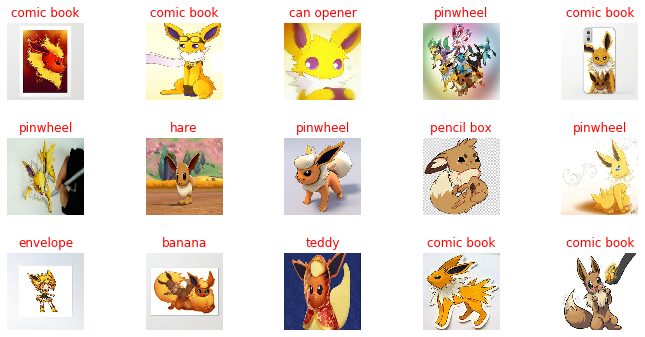

In [32]:
plot_images(image_batch, labels_batch, predicted_class_names)

# RESNET 152 with feature detection for Eevelutions

In [0]:
# feature_extractor_url = 'https://tfhub.dev/google/imagenet/resnet_v2_152/feature_vector/4'
# feature_extractor_url = 'https://tfhub.dev/google/imagenet/resnet_v2_101/feature_vector/4'
feature_extractor_url = "https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/4"

In [0]:
feature_extractor_layer = hub.KerasLayer(feature_extractor_url,
                                         input_shape=IMAGE_SIZE+(3,))

In [35]:
feature_batch = feature_extractor_layer(image_batch)
print(feature_batch.shape)

(32, 2048)


In [0]:
feature_extractor_layer.trainable = False

## Adding the classification head

In [41]:
simple_model = Sequential([
  feature_extractor_layer,
  Dense(1024, activation='relu'),
  Dense(1, activation='sigmoid')
  # Conv2D(32, kernel_size=(3, 3),
  #                activation='relu'),
  # Conv2D(64, (3, 3), activation='relu'),
  # MaxPooling2D(pool_size=(2, 2)),
  # Dropout(0.25),
  # # Flatten(),
  # Dense(128, activation='relu'),
  # Dropout(0.5),
  # Dense(8, activation='softmax')
])


simple_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_1 (KerasLayer)   (None, 2048)              23564800  
_________________________________________________________________
dense_2 (Dense)              (None, 1024)              2098176   
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 1025      
Total params: 25,664,001
Trainable params: 2,099,201
Non-trainable params: 23,564,800
_________________________________________________________________


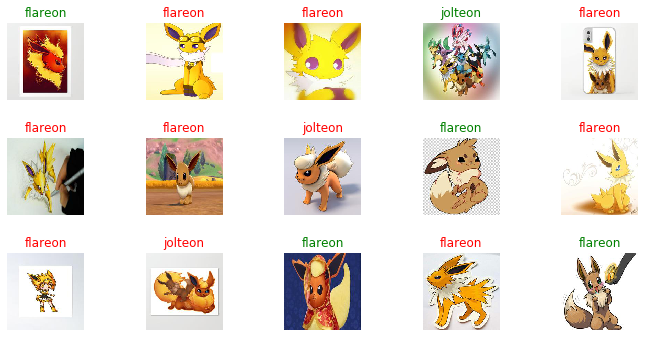

In [42]:
predictions = simple_model(image_batch)
predicted_class_names = np.array(class_names)[np.rint(predictions).astype('int32')].flatten()
plot_images(image_batch, labels_batch, predicted_class_names)

## Training the model

In [0]:
simple_model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
# simple_model.compile(loss=tf.keras.losses.categorical_crossentropy,
#               optimizer=tf.keras.optimizers.SGD(lr=0.3),
#               metrics=['accuracy'])

In [44]:
history = simple_model.fit(
    train_data_gen,
    epochs=30,
    steps_per_epoch=5,
    verbose=1,
    validation_data=val_data_gen
)

  ...
    to  
  ['...']


  ...
    to  
  ['...']


  ...
    to  
  ['...']


  ...
    to  
  ['...']


Train for 5 steps, validate for 2 steps
Epoch 1/30
5/5 [==============================] - 4s 896ms/step - loss: 1.2899 - accuracy: 0.5562 - val_loss: 0.9157 - val_accuracy: 0.7222
Epoch 2/30
5/5 [==============================] - 1s 137ms/step - loss: 0.5581 - accuracy: 0.7250 - val_loss: 0.8795 - val_accuracy: 0.7500
Epoch 3/30
5/5 [==============================] - 1s 141ms/step - loss: 0.4557 - accuracy: 0.7875 - val_loss: 0.8978 - val_accuracy: 0.7500
Epoch 4/30
5/5 [==============================] - 2s 316ms/step - loss: 0.2893 - accuracy: 0.8718 - val_loss: 1.4224 - val_accuracy: 0.6111
Epoch 5/30
5/5 [==============================] - 1s 134ms/step - loss: 0.2076 - accuracy: 0.9062 - val_loss: 0.8843 - val_accuracy: 0.6667
Epoch 6/30
5/5 [==============================] - 1s 135ms/step - loss: 0.1800 - accuracy: 0.9103 - val_loss: 1.0171 - val_accuracy: 0.6111
Epoch 7/30
5/5 [==============================] - 1s 143ms/step - loss: 0.1209 - accuracy: 0.9688 - val_loss: 1.3909 - v

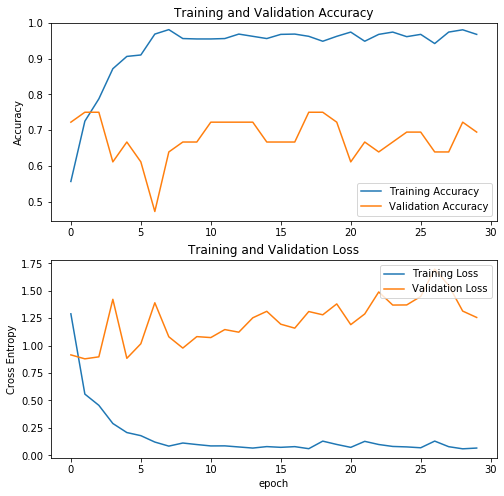

In [45]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
# plt.ylim([0,1.5])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

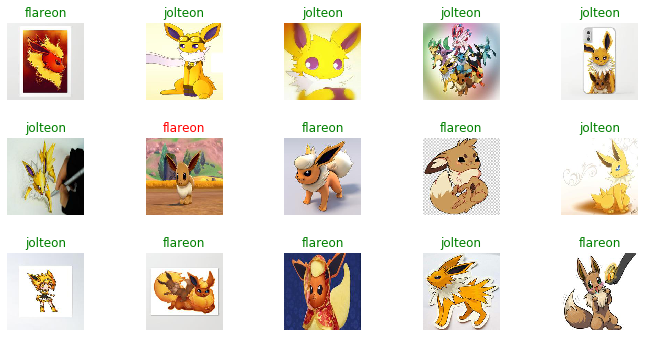

In [46]:
predictions = simple_model(image_batch)
predicted_class_names = np.array(class_names)[np.rint(predictions).astype('int32')].flatten()

plot_images(image_batch, labels_batch, predicted_class_names)